In [608]:
import numpy as np  # NumPy package for arrays, random number generation, etc
import matplotlib.pyplot as plt  # For plotting
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from sklearn.neighbors import KDTree
import networkx as nx

from faker import spatial
from faker import graph

In [609]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [610]:
import logging
logging.basicConfig(level=logging.INFO)

In [613]:
bbox = np.array([[0,0],[100,100]])

In [614]:
centres = spatial.Centres(bbox, density = 0.001)
centres

6 centres

In [615]:
hhs = spatial.Clusters(centres, size=1000, sigma=10)
hhs

5954 units, 6 centres

In [616]:
offices = spatial.Clusters(centres, size=50, sigma=5)
offices

287 units, 6 centres

In [617]:
leisure = spatial.Clusters(centres, size=50, sigma=8)
leisure

296 units, 6 centres

In [618]:
education = spatial.Clusters(centres, size=20, sigma=8)
education

124 units, 6 centres

In [619]:
health = spatial.Clusters(centres, size=10, sigma=8)
health

64 units, 6 centres

(-36.70198739026805,
 132.86022734565483,
 -19.751214108750318,
 136.01658813162993)

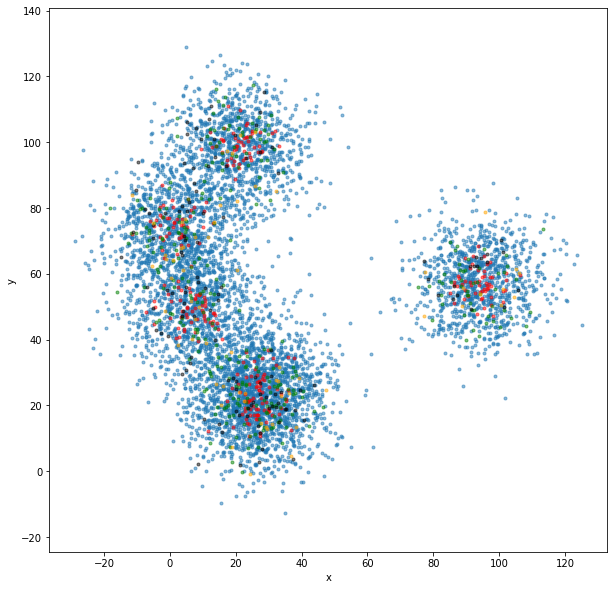

In [620]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(hhs.x, hhs.y, alpha=0.5, marker='.')
ax.scatter(offices.x, offices.y, alpha=0.5, marker='.', c='r')
ax.scatter(leisure.x, leisure.y, alpha=0.5, marker='.', c='g')
ax.scatter(education.x, education.y, alpha=0.5, marker='.', c='black')
ax.scatter(health.x, health.y, alpha=0.5, marker='.', c='orange')
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')

In [621]:
# adjust bbox
bbox = hhs.bbox
bbox

array([[-28.99192582, -12.66810008],
       [125.15016578, 128.9334741 ]])

In [622]:
pop_size = hhs.len
pop_size

5954

In [623]:
def minmax(array, axis=0):
    if len(array.shape) > 1:
        return (array - array.min(axis=axis)) / (array.max(axis=axis) - array.min(axis=axis))
    else:
        return (array - min(array)) / (max(array) - min(array))

In [624]:
# build some hidden features for households

In [625]:
# points
hh_locs = [Point(x, y) for x, y in zip(hhs.x,hhs.y)]
centres_locs = [Point(x, y) for x, y in zip(centres.x, centres.y)]
hh_centres = [Point(x, y) for x, y in zip(hhs.cx, hhs.cy)]

hh_dist_to_centre = np.array([x.distance(y) for x, y in zip(hh_locs, hh_centres)])
hh_dist_to_centre_mm = minmax(hh_dist_to_centre)

In [626]:
# centres tree
tree = KDTree(centres.locs)

dist_closest_centre, _ = tree.query(hhs.locs, dualtree=True, k=1)
dist_closest_centre = dist_closest_centre.reshape(-1)
hh_dist_closest_centre_mm = minmax(dist_closest_centre)

nearest_dist, _ = tree.query(hhs.locs, dualtree=True, k=3)
dist_closest_centres = nearest_dist.sum(axis=1)
hh_dist_closest_centres_mm = minmax(dist_closest_centres)

In [627]:
# hh locations tree
tree = KDTree(hhs.locs)
density = tree.query_radius(hhs.locs, count_only=True, r=1)
hh_density_mm = minmax(density)

In [628]:
hh_locs_mm = minmax(hhs.locs)
hh_centre_ids_mm = minmax(hhs.ids)

In [629]:
# build some attributes based on these hidden features and on each other

In [630]:
def gen_hidden(xx, yy, hh_density_mm):
    """
    hidden household variable
    """
    p1 = np.random.poisson(xx*10)
    p2 = np.random.poisson(hh_density_mm*10)
    p3 = np.random.poisson(hh_density_mm*xx*10)
    p4 = np.random.poisson(((xx - .5)*10)**2)
    p5 = np.random.poisson(yy*10)
    choice = np.array([p1,p2,p3,p4,p5])
    choice = choice/sum(choice)
    return np.random.choice([1,2,3,4,5], p=choice)

In [631]:
def gen_hh_count(hidden, density):
    """
    num people in household
    """
    p1 = density*50 + hidden*2
    p2 = density*40 + hidden*4
    p3 = density*30 + hidden*6
    p4 = density*20 + hidden*8
    p5 = density*10 + hidden*10
    choice = np.array([p1,p2,p3,p4,p5])
    choice = choice/sum(choice)
    return np.random.choice([1,2,3,4,5], p=choice)

In [632]:
hh_hidden = np.array([gen_hidden(x,y,d) for (x,y),d in zip(hh_locs_mm, hh_density_mm)])
hh_count = np.array([gen_hh_count(e,d) for e,d in zip(hh_hidden, hh_density_mm)])


In [633]:
def gen_num_children(count, hidden, hh_dist_closest_centre_mm):
    """
    1 person = a
    2 persons = aa, ac
    3 persons = aaa, aac, acc
    4 people = aaaa, aaac, aacc, accc
    5 people = aaaaa, aaaac, aaacc, aaccc, acccc
    
    """
    if count == 1:
        return 0
    
    else:
        pchild = hh_dist_closest_centre_mm * count / 2
        padult = hidden / 5
        p = pchild / (pchild + padult)
        return np.random.binomial((count - 1), p, size=None)

In [634]:
hh_children = np.array([gen_num_children(c,h,d) for c,h,d in zip(hh_count, hh_hidden, hh_dist_closest_centre_mm)])

In [635]:
sum(hh_count)

19985

In [636]:
sum(hh_children)

6875

In [637]:
def gen_age_group(hh_children, hh_hidden, hh_density_mm):
    
    if hh_children:
        return int(np.random.uniform(16, 16 + hh_hidden) + np.random.triangular(0, 3 * hh_hidden, 20))
    
    old = 50 + (2*hh_hidden)
    adult = 30 + (2*hh_hidden)
    return np.random.choice(
        [
            int(np.random.poisson(old)),
            int(np.random.poisson(adult)),
        ],
        p=(1-hh_density_mm, hh_density_mm)
    )

In [638]:
hh_age_group = np.array([gen_age_group(c,h,d) for c,h,d in zip(hh_children, hh_hidden, hh_density_mm)])

In [639]:
def get_income(hh_dist_closest_centres_mm, hh_density_mm):
    return (15 + np.random.poisson(5*(hh_dist_closest_centres_mm + 1 - hh_density_mm))*5)*1000

In [640]:
hh_income = np.array([get_income(d, s) for d, s in zip(hh_dist_closest_centres_mm, hh_density_mm)])
hh_income_mm = minmax(hh_income)

In [641]:
def get_cars(hh_hidden, income_mm, density_mm, hh_count, hh_children):
    adults = hh_count - hh_children
    p1 = income_mm * (1 - density_mm)
    if hh_hidden < 3:
        p1 /=2
    p2 = p1 / 2
    return np.random.binomial(1, p1) + np.random.binomial(adults-1, p2)

In [642]:
hh_cars = np.array([get_cars(a,b,c,d,e) for a,b,c,d,e in zip(hh_hidden, hh_income_mm, hh_density_mm, hh_count, hh_children)])

In [643]:
from faker.tree import RegularBlock

In [644]:
hh_indexes = np.array(range(len(hhs.locs)))
hh_indexes.shape

(5954,)

In [645]:
hhs.locs.shape

(5954, 2)

In [646]:

data = np.zeros((hhs.len, 3))
data[:,0] = hh_indexes
data[:,1:] = hhs.locs
hh_locs_array.shape

(1459, 3)

In [661]:
grid = RegularBlock(bbox=bbox, data=data, max_points=500)

In [662]:
geom_data = []
geom_maps = []
G = nx.DiGraph()
idx = 0

for block in grid.traverse():
    
    if block.leaf:
        geom_data.append({'block_id': idx, 'density': block.density(), 'geometry': block.district()})
        geom_maps.append(block.build_point_data(idx))
        
    block.build_block_net(idx, G)
    
    idx += 1
        
hh_grid_ids = np.concatenate(geom_maps)
hh_grid_ids = hh_grid_ids[hh_grid_ids[:,0].argsort()]
hh_grid_ids = hh_grid_ids[:,1]

In [663]:
block_df = pd.DataFrame(geom_data)
block_gdf = gpd.GeoDataFrame(block_df, geometry='geometry')

block_gdf.head()

,block_id,density,geometry
0,2,0.040317,"POLYGON ((-28.99193 -12.66810, 9.54360 -12.668..."
1,4,0.026390,"POLYGON ((-28.99193 22.73229, -9.72416 22.7322..."
2,5,0.117287,"POLYGON ((-28.99193 40.43249, -9.72416 40.4324..."
3,6,1.035060,"POLYGON ((-9.72416 40.43249, 9.54360 40.43249,..."
4,7,0.422234,"POLYGON ((-9.72416 22.73229, 9.54360 22.73229,..."


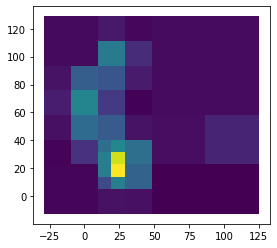

In [664]:
block_gdf.plot(column='density')

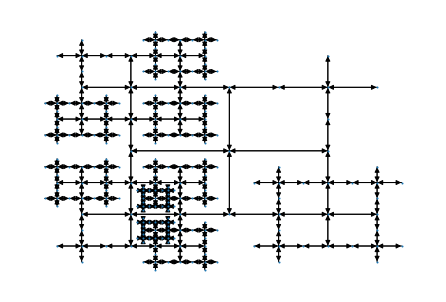

In [665]:
pos = {k: v['pos'] for k, v in G.nodes.items()}
nx.draw(G, pos=pos, node_size=1)

In [666]:
ods = graph.NodesOD(G)

In [667]:
ods.od.shape

(245, 245)

In [279]:
# assemble hh variables            
hh_array = np.stack(
    [
        hh_indexes,
        hh_grid_ids,
        centre_ids,
        hh_dist_to_centre_mm,
        hh_dist_closest_centres_mm,
        hh_density_mm,
        hh_hidden,
        hh_count,
        hh_children,
        hh_age_group,
    ]
, axis=1)

In [280]:
hh_array.shape

(1459, 10)

In [281]:
agent_hh_array = np.repeat(hh_array, hh_count, axis=0)

In [282]:
agent_hh_array.shape

(5088, 10)

In [283]:
agent_index = np.array(range(len(agent_hh_array)))

In [284]:
# get ident for each agent in hh
# _, _, counts = np.unique(sorted_records_array, return_counts=True, return_index=True)
agent_hh_index = np.array([i for c in hh_count for i in range(c)])

In [285]:
agent_hh_index.shape

(5088,)

In [286]:
def get_is_adult(agent_hh_index, hh_array):
    num_children = hh_array[-2]
    if agent_hh_index < num_children:
        return 0
    else:
        return 1

In [287]:
agent_is_adult = np.array([get_is_adult(i,c) for i,c in zip(agent_hh_index, agent_hh_array)])

In [288]:
agent_is_adult.shape

(5088,)

In [289]:
def get_gender(agent_hh_index, agent_hh_array, agent_is_adult):
    
    if not agent_is_adult:
        pman=.49
        return np.random.choice([0, 1], p=[pman, 1-pman])
    
    elif agent_hh_array[-1]:  # number of children
        number_adults = agent_hh_array[-3] - agent_hh_array[-2]
        adult_index = agent_hh_index - agent_hh_array[-2]
        p = agent_hh_array[-4] / 10 # hidden hh
        if adult_index % 2:
            return np.random.choice([0, 1], p=[1 - p, p])
        else:
            return np.random.choice([0, 1], p=[p, 1-p])
    else:
        return np.random.choice([0, 1], p=[.48, .52])
        

In [290]:
agent_genders = np.array([get_gender(i,c,a) for i,c,a in zip(agent_hh_index, agent_hh_array, agent_is_adult)])

In [291]:
agent_genders

array([1, 1, 0, ..., 1, 0, 1])

In [292]:
def get_age(agent_hh_array, agent_is_adult):
    
    hh_hidden = agent_hh_array[-4]
    hh_age_group = agent_hh_array[-1]
    
    if not agent_is_adult:
        return int(np.random.uniform(0, 11) + np.random.triangular(0, hh_hidden, 6))
    
    return hh_age_group + int(np.random.poisson(2))
    

In [293]:
agent_ages = np.array([get_age(i,c) for i,c in zip(agent_hh_array, agent_is_adult)])

In [ ]:
def get_dist_pt(dist_closest_centre):
    return np.random.normal(1-dist_closest_centre)**2

In [ ]:
dist_pt = np.array([get_dist_pt(d) for d in dist_closest_centre])

In [ ]:
income = np.array([get_income(d) for d in dist_closest_centres_mm])

In [ ]:
income_mm = minmax(income)

In [ ]:
def get_car(ethnicity, income_mm, density_mm):
    p = income_mm * (1 - density_mm)
    if ethnicity < 3:
        p /=2 
    choice = np.array([p, 1-p])
    return np.random.choice([1, 0], p=choice)

In [ ]:
has_car = np.array([get_car(e, i, d) for e, i, d in zip(ethnicity, income_mm, density_mm)])

In [ ]:
# build df

In [ ]:
data_dict =  {
        'x': xx,
        'y': yy,
        'centre_id': centre_ids,
        'dist_centre': dist_to_centre,
        'density': density,
        'gender': genders,
        'ethnicity': ethnicity,
        'hh_people': hh_people,
        'age': age,
        'dist_pt': dist_pt,
        'income': income,
        'has_car': has_car
    }

In [ ]:
for k,v in data_dict.items():
    print(k, len(v))

In [ ]:
data = pd.DataFrame(data_dict)

In [ ]:
data.head()

In [ ]:
data.to_csv('data.csv', index=False)

In [ ]:
from faker.tree import RegularBlock
import numpy as np

In [ ]:
xx = np.array((2,1,2,3,6,1,9,1,7))
yy = np.array((0,1,1,3,3,4,1,9,9))

In [ ]:
locs = np.stack((xx,yy), axis=1)

In [ ]:
ind = np.array(range(len(locs))).reshape((-1,1))

In [ ]:
data = np.concatenate((ind,locs), axis=1)
data

In [ ]:
np.concatenate([data,data])

In [ ]:
a = np.ones((3)) * 3
a

In [ ]:
np.concatenate((a,a))

In [ ]:
bbox = np.array([[0,0],[10,10]])

In [ ]:
grid = RegularBlock(bbox, data, 4)

In [ ]:
for leaf in grid.traverse():
    if leaf.leaf:
        print(leaf.centre)

In [ ]:
bbox = np.array([[0,0],[10,10]])
print(bbox)
centre = bbox.mean(axis=0)
print(centre)
left = data[:, 1] < centre[0]
bottom = data[:, 2] < centre[1]
print(left)
print(bottom)
# bottom left
minx, miny, maxx, maxy = bbox[0, 0], bbox[0, 1], centre[0], centre[1]
bbox = np.array([[minx, miny], [maxx, maxy]])
bbox

In [ ]:
bb = np.array([[2,-2],[10,10]])
bb

In [ ]:
bb.mean(axis=0)

In [ ]:
from shapely.geometry import Polygon, MultiPolygon
p1 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p2 = Polygon([(1, 0), (2, 0), (2, 1), (1, 1)])
m = MultiPolygon([p1,p2])

In [ ]:
x,y = m.exterior.xy
plt.plot(x, y)

In [46]:
from enum import Enum, IntEnum
class QuadTree:
    "Quadtree"
   
    class Tag(Enum):
        NONE = 0
        SELECTED = 1
        NEIGHBOR = 2
    
    class Child(IntEnum):
        NW = 0
        NE = 1
        SW = 2
        SE = 3

In [49]:
a = ['a','b','c','d']
quad = QuadTree
a[quad.Child.NE]

'b'

In [378]:
from faker import graph

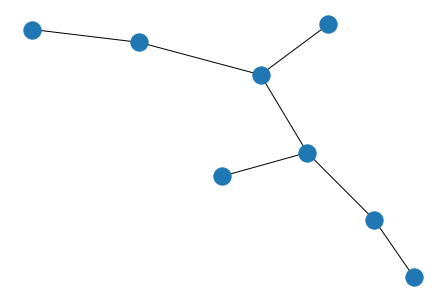

In [385]:
g = nx.binomial_tree(3)
nx.draw(g)

In [382]:
ods = graph.NodesOD(g)
ods.od

array([[0., 1., 1., 2., 1., 2., 2., 3.],
       [1., 0., 2., 3., 2., 3., 3., 4.],
       [1., 2., 0., 1., 2., 3., 3., 4.],
       [2., 3., 1., 0., 3., 4., 4., 5.],
       [1., 2., 2., 3., 0., 1., 1., 2.],
       [2., 3., 3., 4., 1., 0., 2., 3.],
       [2., 3., 3., 4., 1., 2., 0., 1.],
       [3., 4., 4., 5., 2., 3., 1., 0.]])

In [381]:
ods.get(1,2)


2.0

In [395]:
np.zeros((3,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.]])